# Final Project: Extension 2
# Wooyoung Chung

In [1]:
import gym
import a3_gym_env
import sys

import torch
from torch.optim import Adam
from torch.distributions.normal import Normal
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy
import matplotlib.pyplot as plt
# sample hyperparameters
batch_size = 10000
epochs = 30
learning_rate = 1e-2
hidden_size = 8
n_layers = 2
clipEpsilon = 0.2

In [2]:
class PendulumNN(nn.Module):
    def __init__(self,input,output,activation=nn.Tanh):
        super(PendulumNN,self).__init__()

        self.gru = nn.RNN(input,60,2)
        self.fc1=nn.Linear(60,60)
        self.fc2=nn.Linear(60,output)

        self.act1 = activation
        log_std = -0.5 * numpy.ones(output, dtype=numpy.float32)
        self.log_std = torch.nn.Parameter(torch.as_tensor(log_std))

        self.hidden = torch.zeros(2, 60)
    def forward(self,x):
        x,h = self.gru(x,self.hidden)
        self.hidden = h.detach()
        x = F.relu(self.fc1(x))
        x=self.fc2(x)
        vout = torch.exp(self.log_std)
        return x, vout

# class PendulumNN(nn.Module):
#     def __init__(self,input,output,activation=nn.Tanh):
#         super(PendulumNN,self).__init__()
#         self.fc1=nn.Linear(input,90)
#         self.fc2=nn.Linear(90,90)
#         self.fc3=nn.Linear(90,90)
#         self.fc4=nn.Linear(90,output)
#         self.act1 = activation
#         log_std = -0.5 * numpy.ones(output, dtype=numpy.float32)
#         self.log_std = torch.nn.Parameter(torch.as_tensor(log_std))

#     def forward(self,x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = self.fc4(x)
#         vout = torch.exp(self.log_std)
#         return x, vout

In [3]:
class PPOModels():
    def __init__(self,learningRate1,learningRate2):
        self.Actor = PendulumNN(2,1)
        self.Critic = PendulumNN(2,1)
        self.optimActor = Adam(self.Actor.parameters(), lr=learningRate1)
        self.optimCritic = Adam(self.Critic.parameters(), lr=learningRate2)

    def saveModels(self):
        torch.save(self.Actor.state_dict(),"ActorModel.pt")
        torch.save(self.Critic.state_dict(),"CriticModel.pt")
        torch.save(self.optimActor.state_dict(),"optimActor.pt")
        torch.save(self.optimCritic.state_dict(),"optimCritic.pt")

In [4]:
def RewardsToGo(rewards,discountFactor):
    if len(rewards) == 1:
        return rewards
    RewardNext = RewardsToGo(rewards[1:],discountFactor)
    return [rewards[0]+(1-discountFactor)*RewardNext[0]]+RewardNext

In [5]:

def DoRollout(Models,rollout_size,episode_size,yes):
    obervations =[]
    rewards = []
    actions = []
    logprobs = []
    env=gym.make("Pendulum-v1-custom")
    for i in range(rollout_size):
        episodeRewards = []
        obs = env.reset()
        for j in range(episode_size):
            if i ==0 and yes ==1:
                env.render()
            out_mean,out_variance   = Models.Actor(torch.as_tensor(np.array([obs[:2]])))
            out_action_distribution = Normal(out_mean[0], out_variance)
            action                  = out_action_distribution.sample()
            obervations.append(obs[:2])
            obs, reward, done, info = env.step(action.tolist())
            logprob = out_action_distribution.log_prob(action)
            episodeRewards.append(torch.tensor(reward).tolist())
            actions.append(action.detach().numpy())
            logprobs.append(logprob.detach())
        rewards.append(episodeRewards)
    return obervations,rewards,torch.tensor(numpy.array(actions)),torch.tensor(logprobs)

In [6]:
def getRatio(model,observations,actions,old_logprobs):
    out_mean,out_variance = model.Actor(torch.tensor(numpy.array(observations)))

    for i in range(len(observations)):
        out_mean2_,out_variance2_ = model.Actor(torch.tensor(numpy.array([observations[i]])))
        out_mean[i] = out_mean2_
        out_variance =out_variance2_
        
    dist = Normal(out_mean, out_variance)
    log_probs = dist.log_prob(actions).squeeze()
    return torch.exp(log_probs-old_logprobs)

In [7]:
def CalculateAdvantage(model,observations,RTG):
    V = model.Critic(observations)[0].detach().squeeze()
    Advantage = (torch.tensor(RTG)-V)
    return Advantage

def GeneralAdvantage(model,states,rewards,discountFactor):

    if len(rewards)==1:
        return torch.tensor(rewards[0])
    delta = 1-discountFactor
    Vt = model.Critic(torch.tensor(numpy.array([states[0]])))[0].detach().squeeze()
    VT = torch.pow(torch.tensor(delta),len(states)-1)*model.Critic(torch.tensor(numpy.array([states[0]])))[0].detach().squeeze()
    RTG = RewardsToGo(rewards[:len(states)-1],discountFactor)[0]
    return -Vt+RTG+VT

def CalculateGeneralAdvantage(model, obervations,rewards,discountFactor):
    GeneralAdv =[]
    for i in range(len(rewards)):
        obs = obervations[i*len(rewards[0]):(i+1)*len(rewards[0])]
        for j in range(len(rewards[0])):
            GeneralAdv.append(GeneralAdvantage(model,obs[j:],rewards[i][j:],discountFactor))
    return torch.tensor(GeneralAdv)

In [8]:
def PPO(AdvantageType,UsingClip,batchSize,model,rollout=10,episodes =200,clipEpsilon=0.2,df = 0.01):
    batch_size = batchSize
    rollout_size = rollout
    episode_size= episodes
    epsilon= clipEpsilon
    discountFactor = df
    policy = model
    rtg_list = []
    actorGrad_loss_list = []
    criticGrad_loss_list = []
    iter_count = 1
    
    for i in range(batch_size):
        yes =0 
        if i%100==0:
            yes =1
        observations,rewards,actions,logprobs = DoRollout(policy,rollout_size,episode_size,yes)
        RTG = []
        for j in range(rollout_size):
            RTG+=RewardsToGo(rewards[j],discountFactor) 
        if AdvantageType=="RTG":
            Advantage = CalculateAdvantage(policy,observations,RTG)
        elif AdvantageType=="GAE":
            Advantage = CalculateGeneralAdvantage(policy,observations,rewards,discountFactor)
        else:
            return "ERROR NO ADV TYPE SPECIFIED"
        iter_count += 1
        rtg_list.append(sum(RTG)/rollout_size)
        if i %10 ==0:
            print(i)
            print(sum(RTG))
        for j in range(5):
            ratio = getRatio(policy,observations,actions,logprobs)
            if UsingClip == 1:
                reg =  Advantage*ratio
                clip = torch.clip(ratio, 1 - epsilon, 1 + epsilon) * Advantage
                actorGrad =(-torch.min(reg, clip)).mean()
            else:
                actorGrad = (-(Advantage*ratio)).mean()
            policy.optimActor.zero_grad()
            actorGrad.backward(retain_graph=True)
            policy.optimActor.step()

            V = policy.Critic(torch.tensor(numpy.array(observations)))[0].squeeze()

            for i in range(len(observations)):
                V[i] = policy.Critic(torch.tensor(numpy.array([observations[i]])))[0].squeeze()

            criticGrad = nn.MSELoss()(V, torch.tensor(RTG))
            policy.optimCritic.zero_grad()
            criticGrad.backward()
            policy.optimCritic.step()
            
            if j ==4:
                actorGrad_loss_list.append(actorGrad.item())
                criticGrad_loss_list.append(criticGrad.item())
        policy.saveModels() 

    policy.saveModels()
    print("Saved!")
    return policy, rtg_list, actorGrad_loss_list, criticGrad_loss_list, rewards

In [9]:
def TryModel(model):
    env=gym.make("Pendulum-v1-custom")
    obs = env.reset()
    thetaLst = [np.arccos(obs[0])]
    thetaDotLst = [obs[2]]
    
    for i in range(1000):
        action,_ = model(torch.tensor(numpy.array([obs[:2]])))
        obs, reward, done, info = env.step(action.detach()[0])
        thetaLst.append(np.arccos(obs[0]))
        thetaDotLst.append(obs[2])
#         if reward > minReward:
#             minReward=reward
#             minobs = obs
#         rewards.append(reward.tolist())
    return thetaLst, thetaDotLst

In [10]:
def Environment(AdvantageType,Clip,batch_size,Rollout=10,episodes =200,clipEpsilon=0.2,df = 0.01,lr1=1e-2,lr2=1e-2):
    Model = PPOModels(lr1,lr2)
    return PPO(AdvantageType,Clip,batch_size,Model,Rollout,episodes,clipEpsilon,df)

In [11]:
def SeeForMyself(model):
    env=gym.make("Pendulum-v1-custom")
    obs = env.reset()
    thetaLst = [np.arccos(obs[0])]
    thetaDotLst = [obs[2]]
    
    for i in range(1000):
        env.render()
        action,_ = model(torch.tensor(numpy.array([obs[:2]])))
        obs, reward, done, info = env.step(action.detach().tolist()[0])
        thetaLst.append(np.arccos(obs[0]))
        thetaDotLst.append(obs[2])
#         if reward > minReward:
#             minReward=reward
#             minobs = obs
#         rewards.append(reward.tolist())
    return thetaLst, thetaDotLst

# Extension 2
Add recurrence to the policy and train in the environment with partial observability. E.g., use only the angular velocity, rather than the full state, s =[angle, angular velocity]. 

In [12]:
model, rtg_list, actorGrad_loss_list, criticGrad_loss_list, rewards4 = Environment("GAE",1,3000,10,200,0.2,0.01,0.0003,0.0003)

0
-103504.31084446413
10
-120709.35067984487
20
-132903.14419562425
30
-127980.5072764089
40
-119621.00929474577
50
-120465.26109198687
60
-118716.90910868823
70
-126729.01870526043
80
-118291.56851724246
90
-110532.44563181972
100
-110260.09422317824
110
-121620.22320337809
120
-105491.62063336214
130
-131895.32449786502
140
-118850.6916317693
150
-134781.50101347017
160
-127243.93063589203
170
-115714.64094173173
180
-114349.35408532245
190
-124893.54479719485
200
-130080.87852609801
210
-91814.75823234709
220
-114345.53784017224
230
-99196.96233453248
240
-112311.74575014539
250
-112894.3880159881
260
-102661.4232302794
270
-111967.17275137719
280
-92249.5212451351
290
-93225.31518443671
300
-89419.05849857624
310
-90852.47699964022
320
-90519.87526931021
330
-95370.56371185419
340
-95848.47434060158
350
-90080.36789049779
360
-90549.44032419036
370
-75077.15745581886
380
-92674.6712188476
390
-101433.98911055738
400
-87512.99004477535
410
-88739.62218301627
420
-107452.90291904796


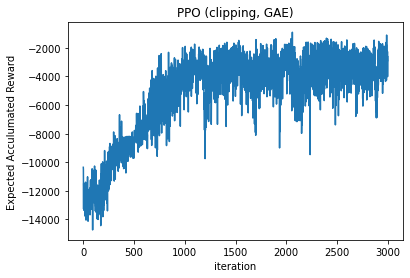

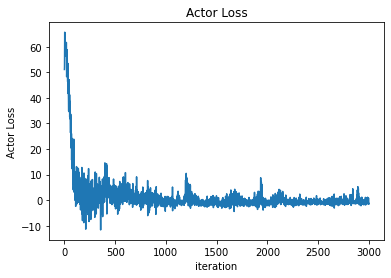

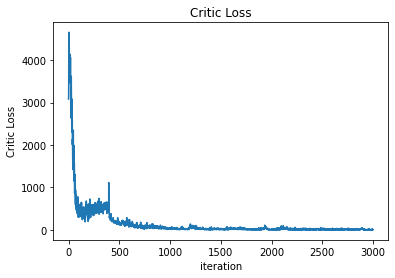

In [13]:
# plot rtg_list
plt.plot(rtg_list)
plt.title("PPO (clipping, GAE)")
plt.xlabel("iteration")
plt.ylabel("Expected Acculumated Reward")
plt.show()
# plot actorGrad_loss_list
plt.plot(actorGrad_loss_list)
plt.title("Actor Loss")
plt.xlabel("iteration")
plt.ylabel("Actor Loss")
plt.show()
# plot criticGrad_loss_list
plt.plot(criticGrad_loss_list)
plt.title("Critic Loss")
plt.xlabel("iteration")
plt.ylabel("Critic Loss")
plt.show()

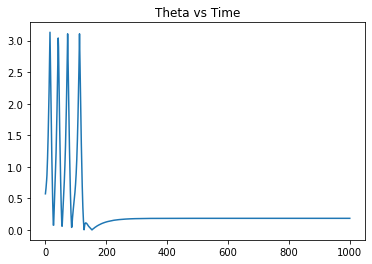

In [14]:
plts = TryModel(model.Actor)
plt.title("Theta vs Time")
plt.plot(plts[0])
plt.show()

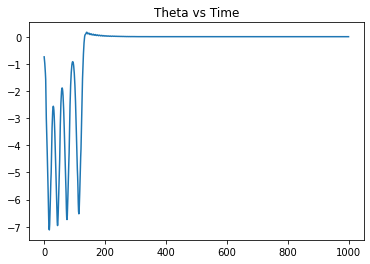

In [15]:
plt.title("Theta vs Time")
plt.plot(plts[1])
plt.show()

In [16]:
# SeeForMyself(model.Actor)

# Discussion
In this extension, we attempted to train a recurrent policy with partial observation to balance a pendulum
## The Coding/Optimization Process
### *Essential* Non-vectorize the prediction of states because we want to sequentially input the states. (For the hidden states)
### *Essetial* Reduce discount factor from 0.99 to 0.9 (help the model focus on learning the next best step)
### Tried LSTM/RNN/GRU but found LSTM and GRU to take extremely long time to compute. Chose to do regular RNN implementation to keep things simple.

## General Analysis:
From our experiment, our model was able to successfully balance a pendulum. But it does have a little difficulty optimizing perfectly. This can be due to either non-optimal parameters or just needs to increase iterations in training.